## Time to get your hands dirty. Galaxies vs quasars with neural networks.

Let's go back to our galaxy vs quasar data we've used in a previous exercise. 

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the [multilayer perceptron classifier](sklearn.neural_network.MLPClassifier) implemented in scikit-learn. My solution uses the latter, but this is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

4. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do your best now to optimize the network architecture. Be creative!

5. Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import datetime

from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.ensemble import GradientBoostingClassifier

from astroML.utils import completeness_contamination

import tensorflow as tf
from tensorflow import keras

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = ['Liberation Serif'] + plt.rcParams['font.serif']
plt.rcParams['font.size']=15
plt.rcParams['figure.figsize']=[6,5]

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Data

In [3]:
data=pd.read_csv('galaxyquasar.csv')

#let's have a look at the data
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [4]:
u_g = np.array(data['u']-data['g'])
g_r = np.array(data['g']-data['r'])
r_i = np.array(data['r']-data['i'])
i_z = np.array(data['i']-data['z'])

# 0=QSO 1=Galaxy

label=np.array(data['class'])
label=np.array(label=='GALAXY', dtype=int)

colors=['u-g', 'g-r', 'r-i', 'i-z']

Rescale and split the data.

In [5]:
#splitting the dataset

X=np.array([u_g,g_r,r_i,i_z]).T

scaler = StandardScaler()
X_s=scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_s, label, test_size=0.3, random_state=1)

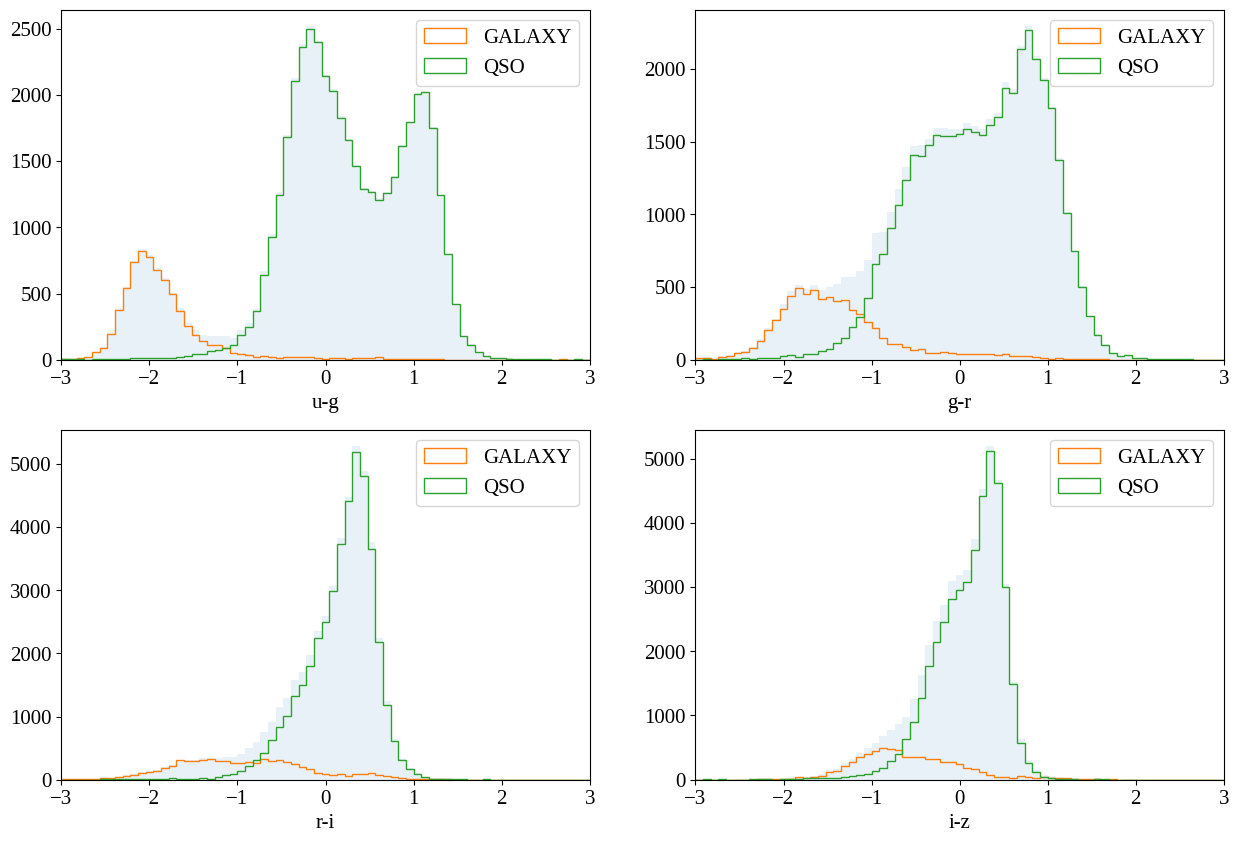

In [6]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10))
axs = [ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]]
bins=np.linspace(-3, 3, 70)

for a,i in zip(axs, range(len(X_s))):
    a.hist(X_s[:,i], bins=bins, alpha=0.1)
    a.hist(X_s[:,i][label==0], bins=bins, histtype='step', lw=1, label='GALAXY')
    a.hist(X_s[:,i][label==1], bins=bins, histtype='step', lw=1, label='QSO')
    
    a.set_xlabel(colors[i])
    a.set_xlim(-3,3)
    a.legend()

plt.show()

### Initial model

Define the initial model, a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a starting learninig rate of `0.001` (which we will decrease after 10 epochs).

In [7]:
def trainnetwork(train_set, test_set, ytrain, ytest, filename):

    if not os.path.isfile(filename):

        train_in  = train_set
        train_out = ytrain
        test_in  = test_set
        test_out = ytest

        # Kernel initializer
        my_init = keras.initializers.glorot_uniform(seed=1)
        # Define neural network architecture
        model = keras.Sequential([
            # Input layer, do not change
            tf.keras.layers.InputLayer(input_shape=np.shape(train_in[0])),
            # Inner layers, can add/change
            keras.layers.Dense(5, activation='relu', kernel_initializer=my_init),
            # Output layer, do not change
            keras.layers.Dense(1, activation='sigmoid',kernel_initializer=my_init)])

        model.compile(
            # Optimization algorithm, specify learning rate
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            # Loss function for a binary classifier
            loss='binary_crossentropy',
            # Diagnostic quantities
            metrics=['accuracy'])

        # Decrease the learning rate exponentially after the first 10 epochs
        def scheduler(epoch, lr):
            if epoch < 10:
                return lr
            else:
                return lr * tf.math.exp(-0.05)

        # Actual Training
        history = model.fit(
            # Training inputs
            train_in,
            # Training outputs
            train_out,
            # Evaluate test set at each epoch
            validation_data=(test_in, test_out),
            # Batch size, default is 32
            #batch_size=32,
            # Number of epochs
            epochs=50,
            # Store the model with the best validation accuracy
            callbacks = [
                # Drecrease learning rate
                tf.keras.callbacks.LearningRateScheduler(scheduler),
                # Store the model with the best validation accuracy
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=filename,
                    save_weights_only=False,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True),
                # Save logfiles for tensorboard
                tf.keras.callbacks.TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime
                                               ("%Y%m%d-%H%M%S"), histogram_freq=1)],
            # Shuffle data at each epoch
            shuffle=True)

        # Store the last (not necessarily the best) iteration
        model.save(filename)

    model = loadnetwork(filename)
    return model


def loadnetwork(filename,verbose=False):
    '''
    Load a trained neural network
    '''

    model = tf.keras.models.load_model(filename)
    if verbose:
        model.summary()

    return model

Train the model and then predict the labels of the train and test sets.

In [10]:
trainnetwork(X_train, X_test, y_train, y_test, filename='gal_QSO_trained.h5')

In [49]:
model = loadnetwork('gal_QSO_trained.h5')

In [12]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

469/469 - 1s - loss: 0.0670 - accuracy: 0.9823 - 520ms/epoch - 1ms/step

Test accuracy: 0.9822666645050049


In [13]:
train_pred = np.squeeze((model.predict(X_train) > 0.5).astype("int32"))
test_pred = np.squeeze((model.predict(X_test) > 0.5).astype("int32"))

469/469 [==============================] - 0s 675us/step


Let's have a look at the classification result.

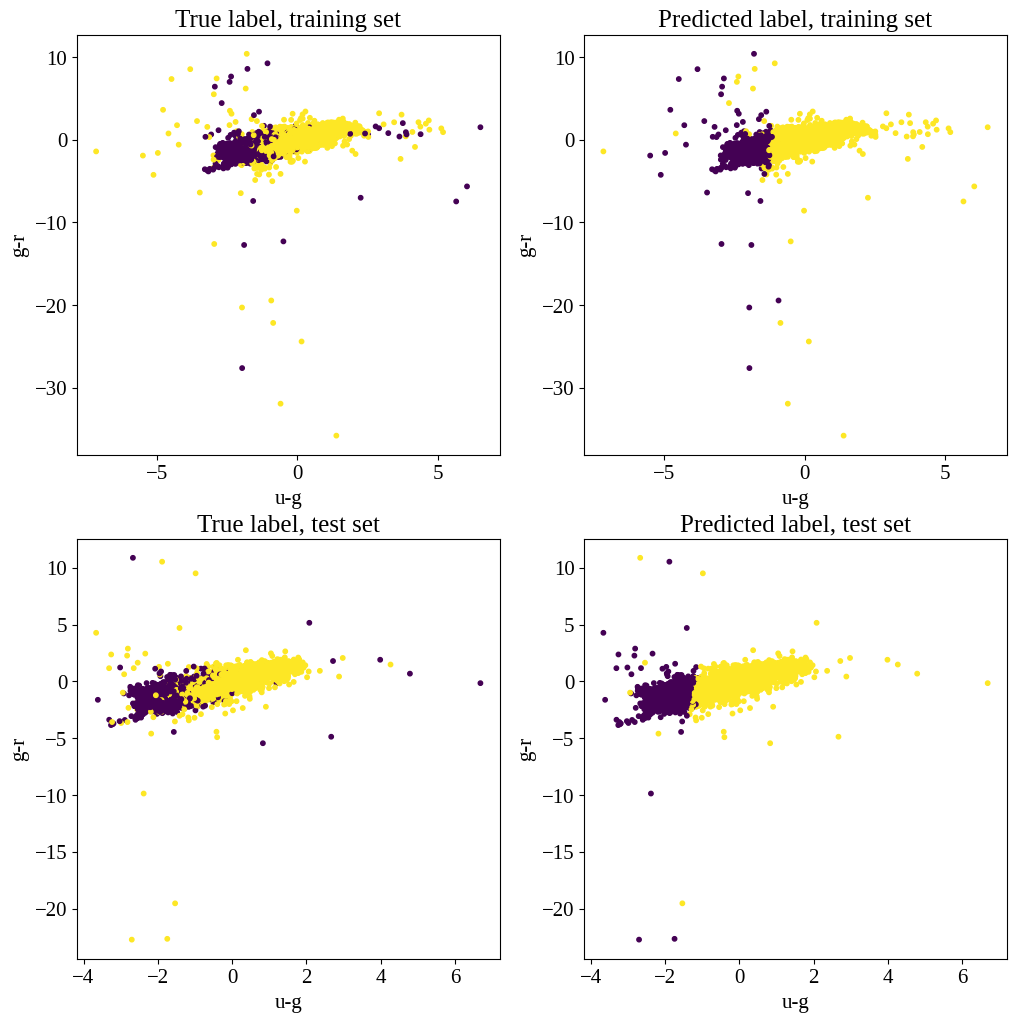

In [14]:
s=10

fig = plt.figure(figsize=(12,12))

ax=fig.add_subplot(221)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=s)
plt.xlabel('u-g')
plt.ylabel('g-r')
plt.title('True label, training set')

ax=fig.add_subplot(222)
plt.scatter(X_train[:,0], X_train[:,1], c=train_pred, s=s)
plt.xlabel('u-g')
plt.ylabel('g-r')
plt.title('Predicted label, training set')

ax=fig.add_subplot(223)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=s)
plt.xlabel('u-g')
plt.ylabel('g-r')
plt.title('True label, test set')


ax=fig.add_subplot(224)
plt.scatter(X_test[:,0], X_test[:,1], c=test_pred, s=s)
plt.xlabel('u-g')
plt.ylabel('g-r')
plt.title('Predicted label, test set')


plt.show()

Consider the true and predicted labels for all the band of the test set.

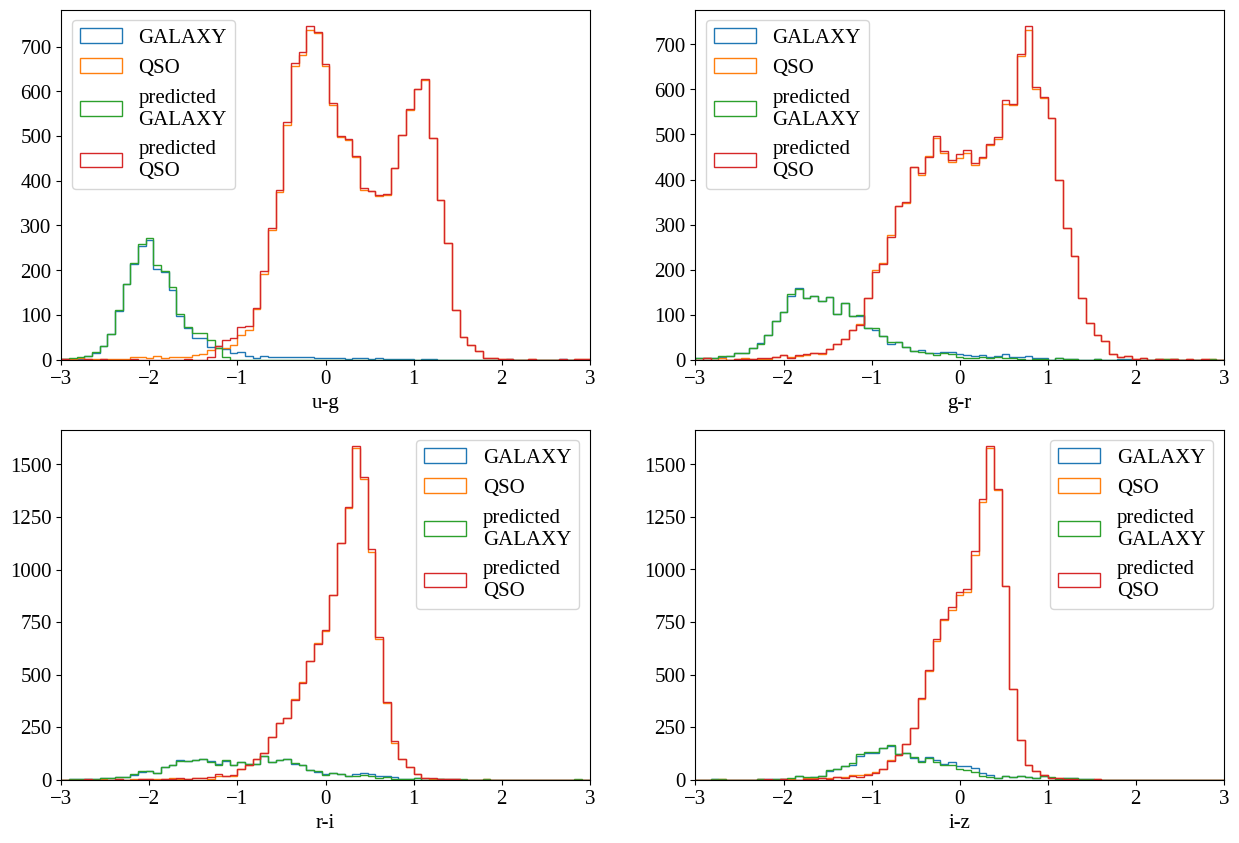

In [15]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10))
axs = [ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]]
bins=np.linspace(-3, 3, 70)

for a,i in zip(axs, range(len(X_s))):
    a.hist(X_test[:,i][y_test==0], bins=bins, histtype='step', lw=1, label='GALAXY')
    a.hist(X_test[:,i][y_test==1], bins=bins, histtype='step', lw=1, label='QSO')
    a.hist(X_test[:,i][test_pred==0], bins=bins, histtype='step', lw=1, label='predicted\nGALAXY')
    a.hist(X_test[:,i][test_pred==1], bins=bins, histtype='step', lw=1, label='predicted\nQSO')
    
    a.set_xlabel(colors[i])
    a.set_xlim(-3,3)
    a.legend()

plt.show()

Seems that the neural network classified the distributions quite well. There are some problems where the two distributions overlap. 

Try to compute the accuracy to quantify this goodness.

In [16]:
accuracy_train = accuracy_score(y_train, train_pred)
accuracy_test = accuracy_score(y_test, test_pred)

print('The accuracy of the training set is:', round(accuracy_train,3))
print('The accuracy of the test set is:', round(accuracy_test,3))

cm_train = confusion_matrix(y_train, train_pred)
cm_test = confusion_matrix(y_test, test_pred)

print('\n Confusion matrix of the training set: \n',  cm_train)
print('\n Confusion matrix of the test set: \n',  cm_test)

completeness, contamination = completeness_contamination(test_pred, y_test)

print("\ncompleteness", round(float(completeness),3))
print("contamination", round(float(contamination),3))

The accuracy of the training set is: 0.982
The accuracy of the test set is: 0.982

 Confusion matrix of the training set: 
 [[ 4541   429]
 [  212 29818]]

 Confusion matrix of the test set: 
 [[ 2005   159]
 [  107 12729]]

completeness 0.992
contamination 0.012


Not bad. We can use [Tensorboard](https://www.tensorflow.org/tensorboard) to visualize the results of the Neural Network; it's useful for example for tracking and visualizing metrics such as loss and accuracy.

In [17]:
%tensorboard --logdir logs/fit

Plot the **ROC** curve and compare it with the `GradientBoostingClassifier`, to have an idea of the performance of the classification.

469/469 [==============================] - 0s 654us/step


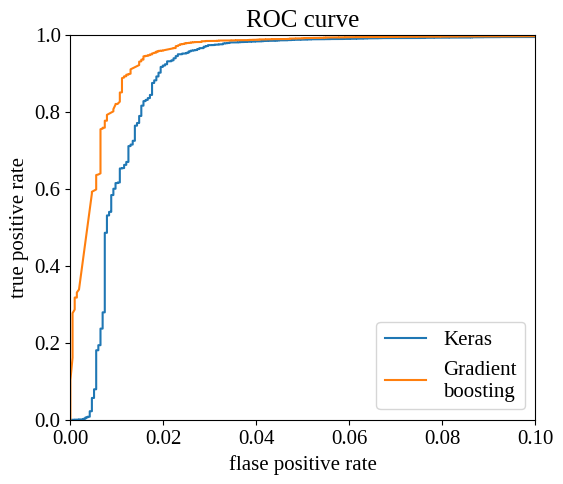

In [54]:
probs=model.predict(X_test)

gradboost = GradientBoostingClassifier()
gradboost.fit(X_train,y_train)
probs_1 = gradboost.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

fpr1, tpr1, thresholds1 = roc_curve(y_test, probs_1)

plt.plot(fpr, tpr, label='Keras')
plt.plot(fpr1, tpr1, label='Gradient\nboosting')
plt.title('ROC curve')
plt.xlabel('flase positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,0.1)
plt.ylim(0.,1)
plt.legend(loc='lower right')
plt.show()

We can do better! Try to tune the hyperparameters of the model using `keras_tuner`.

### Keras tuner

In [20]:
pip install keras-tuner --upgrade

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [23]:
import keras_tuner as kt

First define the model with the hyperparameters to optimize. In this case we are trying to optimize the number of units in the layer (from $4$ to $36$) and the learning rate ($10^{-2}$, $10^{-3}$, $10^{-4}$).

In [21]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(4,)))

  # Tune the number of units in the first Dense layer
  hp_units = hp.Int('units', min_value=4, max_value=36, step=4)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model

Instantiate the tuner to perform the hypertuning, we must specify the hypermodel, the objective to optimize and the maximum number of epochs to train (max_epochs).

In [24]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

INFO:tensorflow:Reloading Tuner from my_dir/intro_to_kt/tuner0.json


Run the hyperparameter search.

In [25]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 16 and the optimal learning rate for the optimizer
is 0.01.



Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.

In [26]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
875/875 [==============================] - 2s 1ms/step - loss: 0.0961 - accuracy: 0.9790 - val_loss: 0.0843 - val_accuracy: 0.9787
Epoch 2/50
875/875 [==============================] - 1s 1ms/step - loss: 0.0756 - accuracy: 0.9825 - val_loss: 0.0826 - val_accuracy: 0.9774
Epoch 3/50
875/875 [==============================] - 1s 1ms/step - loss: 0.0775 - accuracy: 0.9821 - val_loss: 0.0692 - val_accuracy: 0.9829
Epoch 4/50
875/875 [==============================] - 1s 1ms/step - loss: 0.0760 - accuracy: 0.9826 - val_loss: 0.0768 - val_accuracy: 0.9813
Epoch 5/50
875/875 [==============================] - 1s 1ms/step - loss: 0.0724 - accuracy: 0.9825 - val_loss: 0.0674 - val_accuracy: 0.9827
Epoch 6/50
875/875 [==============================] - 1s 1ms/step - loss: 0.0750 - accuracy: 0.9831 - val_loss: 0.0689 - val_accuracy: 0.9840
Epoch 7/50
875/875 [==============================] - 1s 1ms/step - loss: 0.0699 - accuracy: 0.9833 - val_loss: 0.0722 - val_accuracy: 0.9836
Epoch 

Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

In [27]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/48
875/875 [==============================] - 1s 1ms/step - loss: 0.1024 - accuracy: 0.9783 - val_loss: 0.0752 - val_accuracy: 0.9796
Epoch 2/48
875/875 [==============================] - 1s 1ms/step - loss: 0.0798 - accuracy: 0.9828 - val_loss: 0.0812 - val_accuracy: 0.9836
Epoch 3/48
875/875 [==============================] - 1s 1ms/step - loss: 0.0726 - accuracy: 0.9837 - val_loss: 0.0870 - val_accuracy: 0.9819
Epoch 4/48
875/875 [==============================] - 1s 1ms/step - loss: 0.0727 - accuracy: 0.9831 - val_loss: 0.0733 - val_accuracy: 0.9833
Epoch 5/48
875/875 [==============================] - 1s 1ms/step - loss: 0.0688 - accuracy: 0.9839 - val_loss: 0.0798 - val_accuracy: 0.9841
Epoch 6/48
875/875 [==============================] - 1s 1ms/step - loss: 0.0717 - accuracy: 0.9837 - val_loss: 0.0717 - val_accuracy: 0.9844
Epoch 7/48
875/875 [==============================] - 1s 1ms/step - loss: 0.0725 - accuracy: 0.9834 - val_loss: 0.0645 - val_accuracy: 0.9843
Epoch 

And now we proceed as we did before!

In [28]:
train_pred_best = np.squeeze((hypermodel.predict(X_train) > 0.5).astype("int32"))
test_pred_best = np.squeeze((hypermodel.predict(X_test) > 0.5).astype("int32"))

469/469 [==============================] - 0s 675us/step


In [29]:
accuracy_train_best = accuracy_score(y_train, train_pred_best)
accuracy_test_best = accuracy_score(y_test, test_pred_best)

print('The accuracy of the training set is:', round(accuracy_train_best,3))
print('The accuracy of the test set is:', round(accuracy_test_best,3))

cm_train_best = confusion_matrix(y_train, train_pred_best)
cm_test_best = confusion_matrix(y_test, test_pred_best)

print('\n Confusion matrix of the training set: \n',  cm_train_best)
print('\n Confusion matrix of the test set: \n',  cm_test_best)

completeness_best, contamination_best = completeness_contamination(test_pred_best, y_test)

print("\ncompleteness", round(float(completeness_best),3))
print("contamination", round(float(contamination_best),3))

The accuracy of the training set is: 0.985
The accuracy of the test set is: 0.985

 Confusion matrix of the training set: 
 [[ 4576   394]
 [  145 29885]]

 Confusion matrix of the test set: 
 [[ 2025   139]
 [   81 12755]]

completeness 0.994
contamination 0.011


469/469 [==============================] - 0s 663us/step


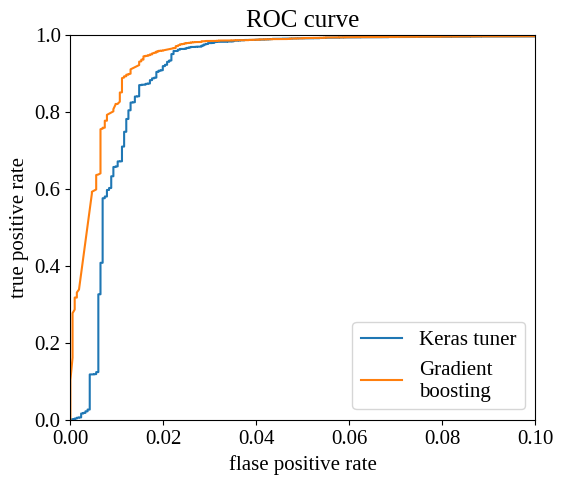

In [55]:
#plt the ROC curve

probs_tune=hypermodel.predict(X_test)

fpr_tune, tpr_tune, thresholds_tune = roc_curve(y_test, probs_tune)

fpr1, tpr1, thresholds1 = roc_curve(y_test, probs_1)

plt.plot(fpr_tune, tpr_tune, label='Keras tuner')
plt.plot(fpr1, tpr1, label='Gradient\nboosting')
plt.title('ROC curve')
plt.xlabel('flase positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,0.1)
plt.ylim(0.,1)
plt.legend(loc='lower right')
plt.show()

With Keras tuner we obtained *slightly* better results. Maybe we can try to increase the number of layers to get better results.

### 2-layers model

Define a model with 2 inner layers: the first with $16$ neurons and the second with $8$ neurons; set the learning rate equal to $10^{-2}$ and decrease it exponentially after $10$ epochs.

In [30]:
def trainnetwork_better(train_set, test_set, ytrain, ytest, filename):

    if not os.path.isfile(filename):

        train_in  = train_set
        train_out = ytrain
        test_in  = test_set
        test_out = ytest

        # Kernel initializer
        my_init = keras.initializers.glorot_uniform(seed=1)
        # Define neural network architecture
        model = keras.Sequential([
            # Input layer, do not change
            tf.keras.layers.InputLayer(input_shape=np.shape(train_in[0])),
            # Inner layers, can add/change
            keras.layers.Dense(16, activation='relu', kernel_initializer=my_init),
            keras.layers.Dense(8, activation='relu', kernel_initializer=my_init),
            # Output layer, do not change
            keras.layers.Dense(1, activation='sigmoid',kernel_initializer=my_init)])

        model.compile(
            # Optimization algorithm, specify learning rate
            optimizer=keras.optimizers.Adam(learning_rate=1e-2),
            # Loss function for a binary classifier
            loss='binary_crossentropy',
            # Diagnostic quantities
            metrics=['accuracy'])

        # Decrease the learning rate exponentially after the first 10 epochs
        def scheduler(epoch, lr):
            if epoch < 10:
                return lr
            else:
                return lr * tf.math.exp(-0.05)

        # Actual Training
        history = model.fit(
            # Training inputs
            train_in,
            # Training outputs
            train_out,
            # Evaluate test set at each epoch
            validation_data=(test_in, test_out),
            # Batch size, default is 32
            #batch_size=32,
            # Number of epochs
            epochs=50,
            # Store the model with the best validation accuracy
            callbacks = [
                # Drecrease learning rate
                tf.keras.callbacks.LearningRateScheduler(scheduler),
                # Store the model with the best validation accuracy
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=filename,
                    save_weights_only=False,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True),
                # Save logfiles for tensorboard
                tf.keras.callbacks.TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime
                                               ("%Y%m%d-%H%M%S"), histogram_freq=1)],
            # Shuffle data at each epoch
            shuffle=True)

        # Store the last (not necessarily the best) iteration
        model.save(filename)

    model = loadnetwork(filename)
    return model


def loadnetwork(filename,verbose=False):
    '''
    Load a trained neural network
    '''

    model = tf.keras.models.load_model(filename)
    if verbose:
        model.summary()

    return model

Train the model as usual, and then predict the labels.

In [31]:
trainnetwork_better(X_train, X_test, y_train, y_test, filename='gal_QSO_trained_better.h5')

In [32]:
model_1 = loadnetwork('gal_QSO_trained_better.h5')

In [33]:
train_pred_1 = np.squeeze((model_1.predict(X_train) > 0.5).astype("int32"))
test_pred_1 = np.squeeze((model_1.predict(X_test) > 0.5).astype("int32"))

469/469 [==============================] - 0s 672us/step


In [34]:
accuracy_train_1 = accuracy_score(y_train, train_pred_1)
accuracy_test_1 = accuracy_score(y_test, test_pred_1)

print('The accuracy of the training set is:', round(accuracy_train_1,3))
print('The accuracy of the test set is:', round(accuracy_test_1,3))

cm_train_1 = confusion_matrix(y_train, train_pred_1)
cm_test_1 = confusion_matrix(y_test, test_pred_1)

print('\n Confusion matrix of the training set: \n',  cm_train_1)
print('\n Confusion matrix of the test set: \n',  cm_test_1)

completeness_1, contamination_1 = completeness_contamination(test_pred_1, y_test)

print("\ncompleteness", round(float(completeness_1),3))
print("contamination", round(float(contamination_1),3))

The accuracy of the training set is: 0.986
The accuracy of the test set is: 0.986

 Confusion matrix of the training set: 
 [[ 4639   331]
 [  153 29877]]

 Confusion matrix of the test set: 
 [[ 2040   124]
 [   85 12751]]

completeness 0.993
contamination 0.01


We obtained almost the same results, the improvement is very small with respect to the tuned model. 

Visualize the result.

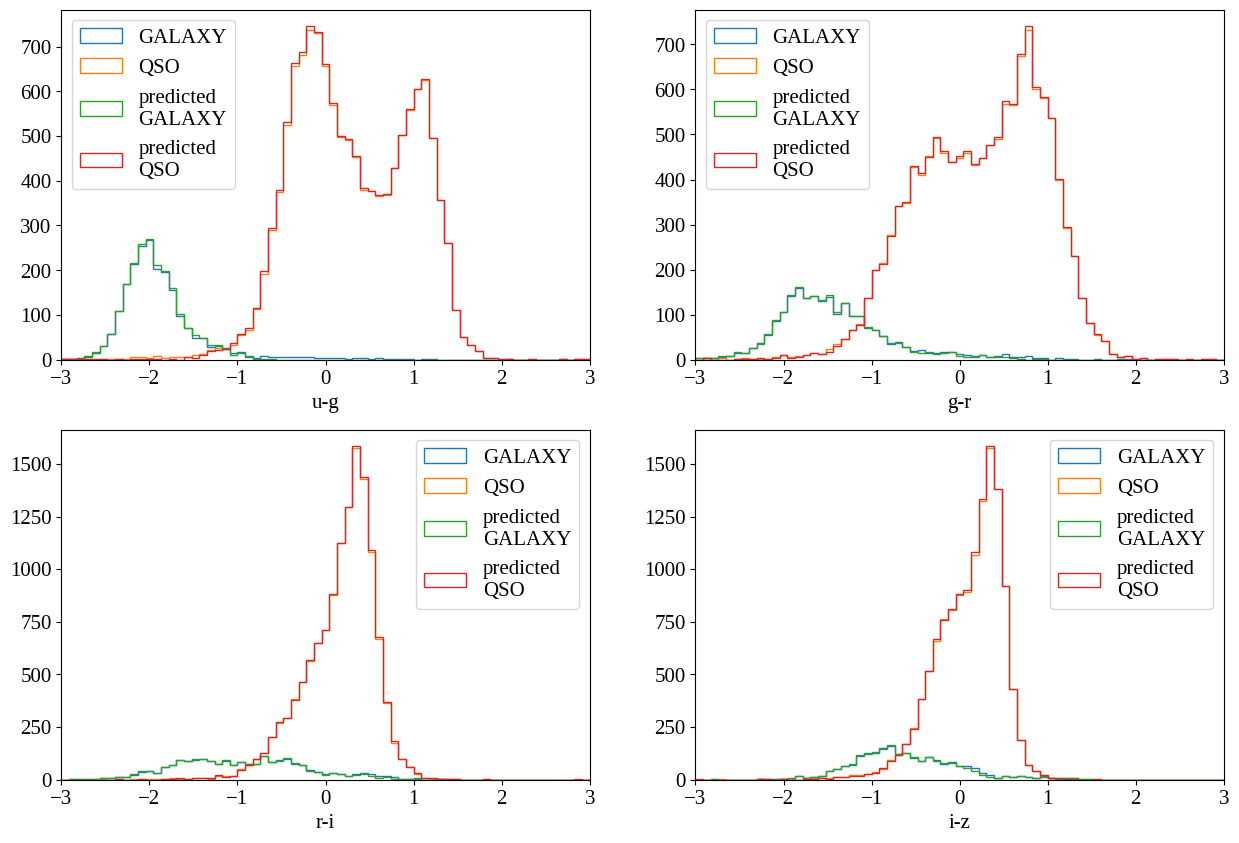

In [58]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10))
axs = [ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]]
bins=np.linspace(-3, 3, 70)

for a,i in zip(axs, range(len(X_s))):
    a.hist(X_test[:,i][y_test==0], bins=bins, histtype='step', lw=1, label='GALAXY')
    a.hist(X_test[:,i][y_test==1], bins=bins, histtype='step', lw=1, label='QSO')
    a.hist(X_test[:,i][test_pred_1==0], bins=bins, histtype='step', lw=1, label='predicted\nGALAXY')
    a.hist(X_test[:,i][test_pred_1==1], bins=bins, histtype='step', lw=1, label='predicted\nQSO')
    
    a.set_xlabel(colors[i])
    a.set_xlim(-3,3)
    a.legend()

plt.show()

It would appear that compared to the initial model we obtained better results. 

Plot the **ROC** curve, again comparing it with the Gradient Boosting classification.

469/469 [==============================] - 0s 718us/step


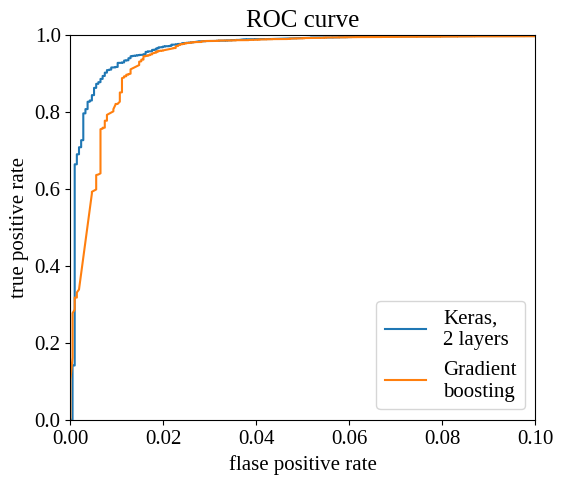

In [56]:
#plt the ROC curve

probs_2l=model_1.predict(X_test)

fpr_2l, tpr_2l, thresholds_2l = roc_curve(y_test, probs_2l)

fpr1, tpr1, thresholds1 = roc_curve(y_test, probs_1)

plt.plot(fpr_2l, tpr_2l, label='Keras,\n2 layers')
plt.plot(fpr1, tpr1, label='Gradient\nboosting')
plt.title('ROC curve')
plt.xlabel('flase positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,0.1)
plt.ylim(0.,1)
plt.legend(loc='lower right')
plt.show()

Seems that we improved our model; let's compare all the results we found.

### Results comparison

In [51]:
gradboost = GradientBoostingClassifier()

gradboost.fit(X_train,y_train)

train_pred_gb = gradboost.predict(X_train)
test_pred_gb = gradboost.predict(X_test)

accuracy_train_gb = accuracy_score(y_train, train_pred_gb)
accuracy_test_gb = accuracy_score(y_test, test_pred_gb)

print('The accuracy of the training set is:', accuracy_train_gb)
print('The accuracy of the test set is:', accuracy_test_gb)

cm_train_gb = confusion_matrix(y_train, train_pred_gb)
cm_test_gb = confusion_matrix(y_test, test_pred_gb)

print('\n Confusion matrix of the training set: \n',  cm_train_gb)
print('\n Confusion matrix of the test set: \n',  cm_test_gb)

completeness_gb, contamination_gb = completeness_contamination(test_pred_gb, y_test)

print("\ncompleteness", round(float(completeness_gb),3))
print("contamination", round(float(contamination_gb),3))

The accuracy of the training set is: 0.9878
The accuracy of the test set is: 0.9855333333333334

 Confusion matrix of the training set: 
 [[ 4694   276]
 [  151 29879]]

 Confusion matrix of the test set: 
 [[ 2048   116]
 [  101 12735]]

completeness 0.992
contamination 0.009


In [60]:
from tabulate import tabulate

NN=np.array(["Starting", "Keras Tuner", "2-layers", "Grad. Boost"])
layers=np.array(["1", "1", "2", "/"])
neurons=np.array(["5", "16", "16-8", "/"])
learn_r=np.array(["0.001", "0.01", "0.01", "/"])
acc_train=np.array([accuracy_train, accuracy_train_best, accuracy_train_1, accuracy_train_gb])
acc_test=np.array([accuracy_test, accuracy_test_best, accuracy_test_1, accuracy_test_gb])
complet=np.array([completeness, completeness_best, completeness_1, completeness_gb])
contam=np.array([contamination, contamination_best, contamination_1, contamination_gb])

results = np.array([NN, layers, neurons, learn_r, acc_train, acc_test, complet, contam]).T

col_names=["model", "# layers", "# neurons", "learn. rate", "acc. train", "acc. test", "complet.", "contamin."]

print(tabulate(results, headers=col_names, tablefmt="mixed_grid", stralign="center", numalign="center",
              floatfmt=".4f"))

┍━━━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│    model    │  # layers  │  # neurons  │  learn. rate  │  acc. train  │  acc. test  │  complet.  │  contamin.  │
┝━━━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│  Starting   │     1      │      5      │     0.001     │    0.9817    │   0.9823    │   0.9917   │   0.0123    │
├─────────────┼────────────┼─────────────┼───────────────┼──────────────┼─────────────┼────────────┼─────────────┤
│ Keras Tuner │     1      │     16      │     0.01      │    0.9846    │   0.9853    │   0.9937   │   0.0108    │
├─────────────┼────────────┼─────────────┼───────────────┼──────────────┼─────────────┼────────────┼─────────────┤
│  2-layers   │     2      │    16-8     │     0.01      │    0.9862    │   0.9861    │   0.9934   │   0.0096    │
├─────────────┼────────────┼─────────────┼───────────────┼──────────────┼───────

The improvement of the various models has been very small, but non-zero. Despite that, at the end we obtained quite the same result of Gradient Boosting.

Compare the **ROC** curves of the models.

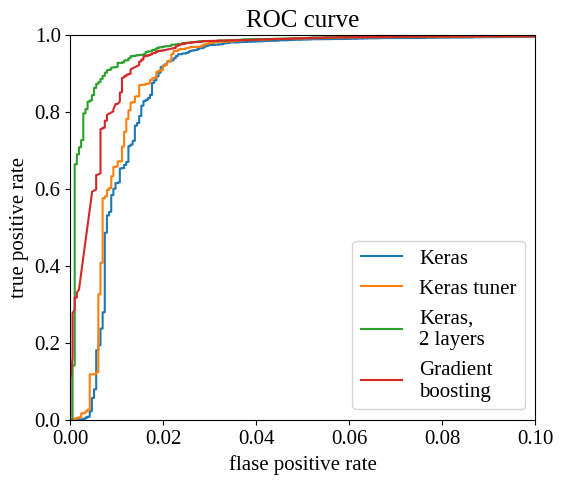

In [57]:
plt.plot(fpr, tpr, label='Keras')
plt.plot(fpr_tune, tpr_tune, label='Keras tuner')
plt.plot(fpr_2l, tpr_2l, label='Keras,\n2 layers')
plt.plot(fpr1, tpr1, label='Gradient\nboosting')
plt.title('ROC curve')
plt.xlabel('flase positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,0.1)
plt.ylim(0.,1)
plt.legend(loc='lower right')
plt.show()

The ROC curves of the two models with $1$ layer are below the one of the Gradient Boosting; but, if we consider the 2-layers model, we managed to overcome this threshold.